# Filtering signal using overlap and add algorithm
The goal of this notebook is to show how to use overlap and add to filter long signals.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from wavely.signal.preprocessing import preprocessing
from wavely.signal.units import helpers

## Generate a signal with 3 sines of different frequencies

In [2]:
rate = 96e3
f = [100, 10000, 30000]

signal_size = int(rate * 30)
t_v = np.arange(signal_size) / rate
f_v = rate * np.arange(signal_size) / signal_size

signal = (
    np.sin(2 * np.pi * f[0] * t_v)
    + np.sin(2 * np.pi * f[1] * t_v)
    + np.sin(2 * np.pi * f[2] * t_v)
)

## Create a filter without using overlap and add

In [3]:
cutoff = 15000
filter_type = "highpass"

In [4]:
butter_filter = preprocessing.make_butter_filter(
    cutoff=cutoff,
    rate=rate,
    filter_type=filter_type,
    order=10,
)

filtered_signal = butter_filter(signal)
spectrum = np.fft.fft(filtered_signal)[: signal_size // 2]

<IPython.core.display.Javascript object>


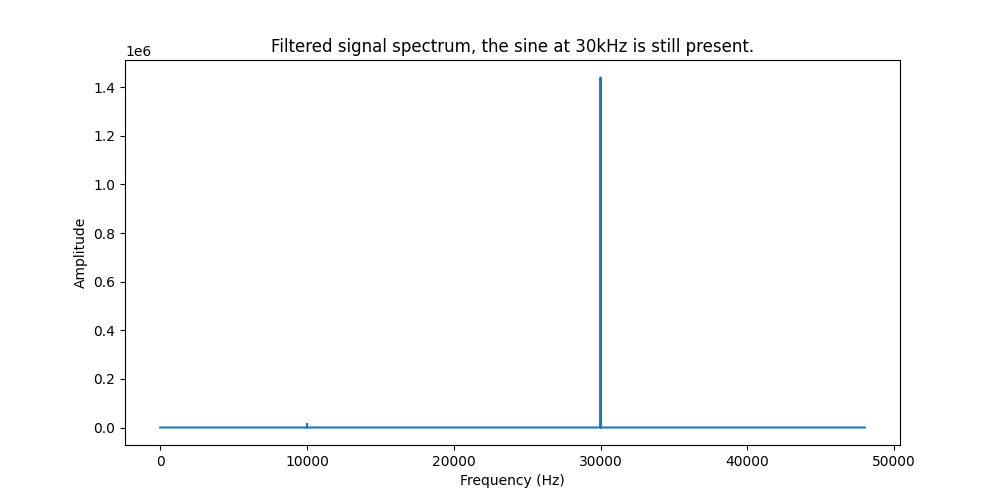

Text(0.5, 1.0, 'Filtered signal spectrum, the sine at 30kHz is still present.')

In [5]:
plt.figure(1, figsize=(10, 5))
plt.plot(f_v[: signal_size // 2], np.abs(spectrum))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Filtered signal spectrum, the sine at 30kHz is still present.")

## Create a filter using overlap and add

In [6]:
butter_filter = preprocessing.make_butter_filter(
    cutoff=cutoff,
    rate=rate,
    filter_type=filter_type,
    order=10,
)
butter_filter_overlap_add = preprocessing.make_overlap_and_add_filter(
    rate=rate,
    filter_callable=butter_filter
)

filtered_signal_overlap_add = butter_filter_overlap_add(signal)
spectrum_overlap_add = np.fft.fft(filtered_signal_overlap_add)[: signal_size // 2]

<IPython.core.display.Javascript object>


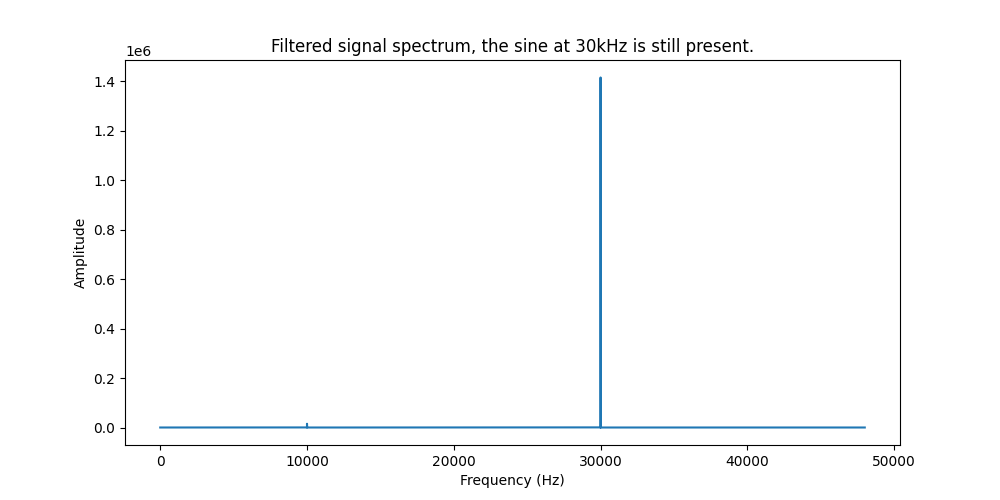

Text(0.5, 1.0, 'Filtered signal spectrum, the sine at 30kHz is still present.')

In [7]:
plt.figure(2, figsize=(10, 5))
plt.plot(f_v[: signal_size // 2], np.abs(spectrum_overlap_add))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Filtered signal spectrum, the sine at 30kHz is still present.")

In [8]:
max_frequency = f_v[np.where(np.abs(spectrum) > np.abs(spectrum).max() // 2)[0][0]]
max_frequency_overlap_add = f_v[np.where(np.abs(spectrum_overlap_add) > np.abs(spectrum_overlap_add).max() // 2)[0][0]]

In [9]:
print("Target remaining frequency: {}".format(f[2]))
print("Remaining frequency without overlap add: {}".format(max_frequency))
print("Remaining frequency with overlap add: {}".format(max_frequency_overlap_add))

Target remaining frequency: 30000
Remaining frequency without overlap add: 30000.0
Remaining frequency with overlap add: 30000.0


## Explanation about overlap add
The signal is filtered using the overlap and add algorithm. It consists in splitting the signal, filtering each block and then reconstructing the signal from the filtered blocks.
The signal is split into blocks using `helpers.split_signal`, the blocks being overlapped by a factor 0.5.
The blocks are windowed using a "square root" hanning window. The reason will be explained later. 
Then each block is filtered using the desired filter. The filtered blocks are also windowed by the square root hanning window.
The combination of square root hanning window and 0.5 overlap ensure a perfect reconstruction of the signal.
Then signal is reconstructed from the blocks using `helpers.reconstruct_signal`: The first block is added to the reconstructed signal, then the next block is added to the reconstructed signal (which overlap with the previous block), etc.

## Real-time overlap and add
You can use the `OverlapAndAddFilter` to perform overlap and add in real-time. The blocks you pass can either be with overlap or without overlap.

In [10]:
block_duration = 0.04
are_blocks_with_overlap = False
overlap_ratio = 0.5
overlap_and_add_filter = preprocessing.OverlapAndAddFilter(
    filter_func=butter_filter,
    block_duration=block_duration,
    rate=rate,
    are_blocks_with_overlap=are_blocks_with_overlap,
    overlap_ratio=overlap_ratio,
)

In [11]:
blocks = helpers.split_signal(
    signal=signal,
    rate=rate,
    block_duration=block_duration,
    overlap_ratio=0.5
)

n_blocks = 100
filtered_blocks = np.zeros_like(blocks)
n_batches = int(blocks.shape[0] / n_blocks)

for batch in range(n_batches):
    overlap_and_add_filter.push(
        blocks[slice(batch * n_blocks, (batch + 1) * n_blocks), :]
    )
    filtered_blocks[
        slice(batch * n_blocks, (batch + 1) * n_blocks)
    ] = overlap_and_add_filter.pop_blocks().squeeze()
overlap_and_add_filter.push(
    blocks[slice(n_batches * n_blocks, blocks.shape[0]), :]
)
filtered_blocks[
    slice(n_batches * n_blocks, blocks.shape[0])
] = overlap_and_add_filter.pop_blocks().squeeze()

filtered_signal = helpers.unsplit_signal(
    blocks=filtered_blocks, overlap_ratio=overlap_ratio
)

In [12]:
spectrum_rt_overlap_add = np.fft.fft(filtered_signal)[: signal_size // 2]

<IPython.core.display.Javascript object>


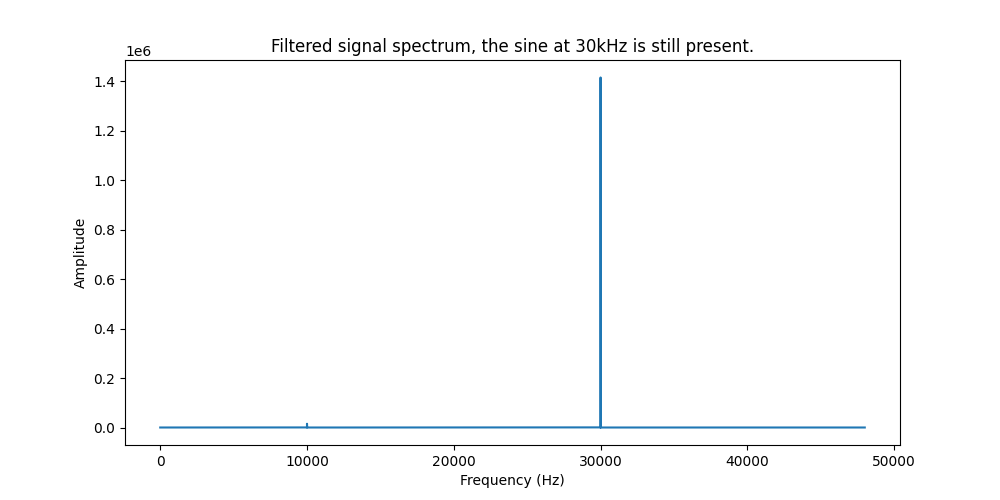

Text(0.5, 1.0, 'Filtered signal spectrum, the sine at 30kHz is still present.')

In [13]:
plt.figure(3, figsize=(10, 5))
plt.plot(f_v[: signal_size // 2], np.abs(spectrum_overlap_add))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Filtered signal spectrum, the sine at 30kHz is still present.")

In [14]:
max_frequency = f_v[np.where(np.abs(spectrum) > np.abs(spectrum).max() // 2)[0][0]]
max_frequency_overlap_add = f_v[np.where(np.abs(spectrum_overlap_add) > np.abs(spectrum_overlap_add).max() // 2)[0][0]]

In [15]:
print("Target remaining frequency: {}".format(f[2]))
print("Remaining frequency without overlap add: {}".format(max_frequency))
print("Remaining frequency with overlap add: {}".format(max_frequency_overlap_add))

Target remaining frequency: 30000
Remaining frequency without overlap add: 30000.0
Remaining frequency with overlap add: 30000.0
